In [327]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# NOT IMPOTANT Load Data

In [394]:
df = pd.read_csv('Final_Cleaned.csv', encoding='utf-8', sep=';')
df_clean = df.drop(columns=['latitude', 'longitude', 'sqm_price'])

In [395]:
new_column_names = {}

# Iterate through the existing column names and generate the new names
for column in df_clean.columns:
    new_name = column.lower().replace(" ", "_")  # Convert to lowercase and replace spaces
    new_column_names[column] = new_name

# Rename the columns using the generated names
df_clean.rename(columns=new_column_names, inplace=True)

In [396]:
df_final = df_clean.drop(columns=['city', 'municipal', 'residents',
                                 'distance_to_copenhagen', 'distance_to_aarhus', 'distance_to_odense', 'distance_to_aalborg'])

In [397]:
# Create dummy variables for the 'Category' column
dummy_1 = pd.get_dummies(df_final['property_type'], prefix='type',drop_first=True)
dummy_2 = pd.get_dummies(df_final['energy'], prefix = 'energy',drop_first=True)
dummy_3 = pd.get_dummies(df_final['closest_city'], prefix = 'close',drop_first=True)

# Concatenate the dummy variables with the original DataFrame
df_final = pd.concat([df_final, dummy_1,dummy_2,dummy_3], axis=1)
df_final = df_final.drop(columns=['property_type','energy','closest_city'])
#df_final

In [398]:
df_final.shape

(26527, 20)

Drop outliers

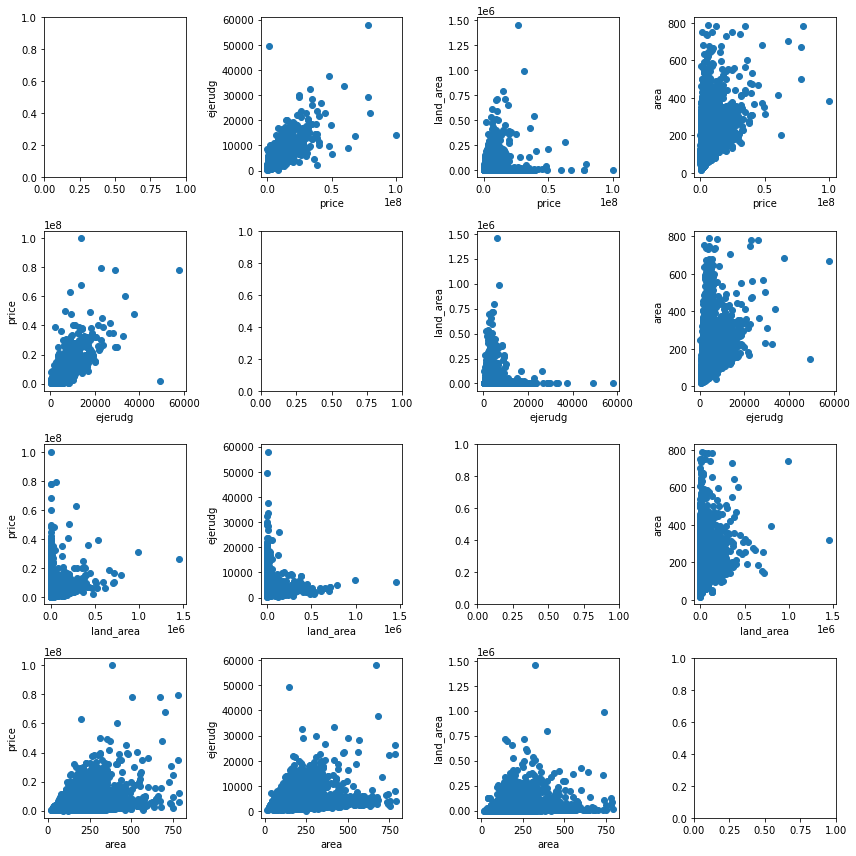

In [399]:
selected_columns = ['price', 'ejerudg', 'land_area', 'area']
# Create scatter plots
fig, axes = plt.subplots(nrows=len(selected_columns), ncols=len(selected_columns), figsize=(12, 12))

for i, col1 in enumerate(selected_columns):
    for j, col2 in enumerate(selected_columns):
        if col1 != col2:
            axes[i, j].scatter(df_final[col1], df_final[col2])
            axes[i, j].set_xlabel(col1)
            axes[i, j].set_ylabel(col2)

plt.tight_layout()
plt.show()

# Save the figure as a JPEG image
fig.savefig('outliers_scatterplot.png', format='png')

In [400]:
z_scores = np.abs((df_final[selected_columns] - df_final[selected_columns].mean()) / df_final[selected_columns].std())

# Define a Z-score threshold to identify outliers
z_threshold = 2.5

# Filter out rows with outliers
outlier_indices = np.where(z_scores > z_threshold)
filtered_indices = list(set(outlier_indices[0]))
df_filtered = df_final.drop(filtered_indices)

# Create scatter plots for filtered data

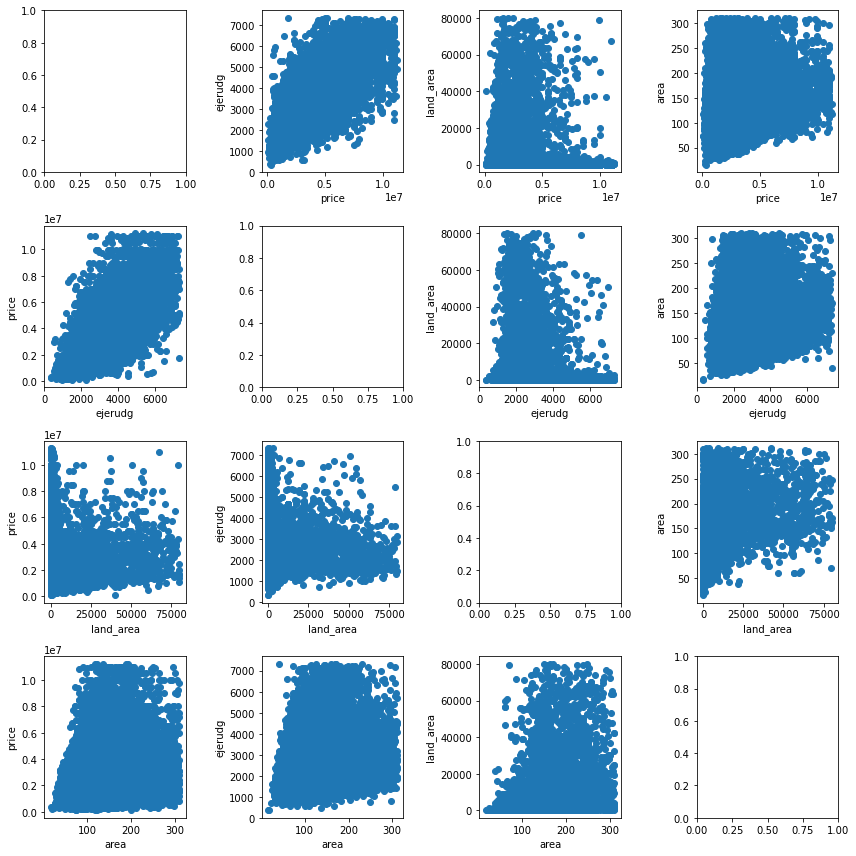

In [401]:
fig, axes = plt.subplots(nrows=len(selected_columns), ncols=len(selected_columns), figsize=(12, 12))

for i, col1 in enumerate(selected_columns):
    for j, col2 in enumerate(selected_columns):
        if col1 != col2:
            axes[i, j].scatter(df_filtered[col1], df_filtered[col2])
            axes[i, j].set_xlabel(col1)
            axes[i, j].set_ylabel(col2)

plt.tight_layout()
plt.show()

# Save the figure as a JPEG image
fig.savefig('no_outliers_scatterplot.png', format='png')

In [402]:
print(df_filtered.shape, df_final.shape)

(24863, 20) (26527, 20)


Drop duplicates

In [372]:
duplicates = df_filtered[df_filtered.duplicated()]
print(duplicates.shape)
df_final = df_filtered.drop_duplicates()
df_final.shape

(39, 20)


(25799, 20)

# START HERE

In [357]:
df_final = pd.read_csv('ml.csv', encoding='utf-8', sep=';')
df_final = df_final.iloc[:, 1:]
df_final.head()

,price,area,land_area,rooms,ejerudg,days_active,distance_to_city,residents,municipal_tax_rate,grundskyldspromille,...,type_Villa,energy_B,energy_C,energy_D,energy_E,energy_F,energy_G,close_Aarhus,close_Copenhagen,close_Odense
0,5195000.0,82.0,563.0,5.0,4894.0,87.0,5.126456,644431.0,23.70,34.00,...,1,0,0,1,0,0,0,0,1,0
1,2595000.0,192.0,20011.0,7.0,2077.0,6.0,72.075634,55340.0,26.30,24.36,...,1,0,0,1,0,0,0,0,0,1
2,3495000.0,116.0,794.0,4.0,3725.0,33.0,20.688457,50818.0,24.42,16.94,...,1,0,0,1,0,0,0,0,1,0
3,4500000.0,159.0,833.0,5.0,2862.0,229.0,42.015572,61718.0,25.26,21.04,...,1,1,0,0,0,0,0,0,1,0
4,1245000.0,157.0,1075.0,6.0,2101.0,105.0,51.888689,51606.0,25.50,26.00,...,1,0,0,1,0,0,0,0,0,1


# Machine learning models

In [373]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV

In [374]:
y = df_final['price']
X = df_final.drop(columns=['price'])

In [375]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Linear Regression

In [376]:
def create_pipeline_lr(degree):
    return make_pipeline(PolynomialFeatures(degree=degree, include_bias=False),
                        StandardScaler(),
                        LinearRegression())

# Loop through polynomial degrees
for degree in [1,2]:
    pipe_lr = create_pipeline_lr(degree)
    
    pipe_lr.fit(X_dev, y_dev)
    y_test_pred = pipe_lr.predict(X_test)

    test_rmse = np.sqrt(mse(y_test, y_test_pred))
    r2 = r2_score(y_test, y_test_pred)
    
    print(f"Degree {degree} Polynomial - R squared: {r2:.4f}")
    print(f"Degree {degree} Polynomial - RMSE: {test_rmse:.2f}")

Degree 1 Polynomial - R squared: 0.7400
Degree 1 Polynomial - RMSE: 1139381.78
Degree 2 Polynomial - R squared: 0.8146
Degree 2 Polynomial - RMSE: 962031.24


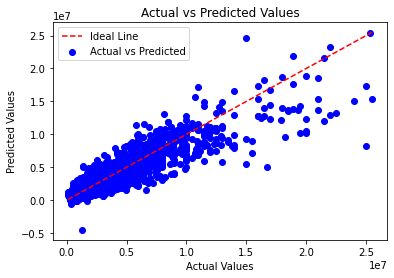

In [362]:
# Plot y_test vs y_pred
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [156]:
coefficients = pipe_lr.get_params(deep=True)
coefficients = pipe_lr.named_steps['linearregression'].coef_
print("Coefficients:", coefficients)
scaling_factors = pipe_lr.named_steps['standardscaler'].scale_
rescaled_coefficients = coefficients / scaling_factors

Coefficients: [ 5.49603707e+06 -7.94742573e+05  2.47902498e+06  1.60609768e+05
 -1.21181541e+05 -6.82529401e+06  1.77836727e+06  1.85464694e+06
  2.83475647e+06 -9.18817020e+16  4.18790220e+17 -1.20643496e+18
 -1.49624010e+18 -3.89188415e+18 -1.49008346e+18  2.45389824e+18
  1.86142607e+18  8.44209602e+15  5.19116316e+17 -2.14322706e+05
  1.45978586e+05 -1.28341295e+05  3.44996831e+05  7.77035497e+04
 -2.00488665e+05 -2.94240305e+06  1.16263653e+05 -1.96687391e+05
 -1.77923318e+06 -4.45989949e+05 -1.20326488e+06 -1.23840595e+06
 -8.89916924e+05 -6.11419598e+05 -5.05392800e+05  4.60016430e+04
  1.55942956e+05  9.53183369e+04  4.63874051e+04  1.43090157e+05
 -2.01728185e+05  1.59236330e+02  2.98506483e+02  5.10232564e+05
  1.86436933e+05 -1.43994392e+05  6.72335674e+04  2.39108376e+04
  1.10987054e+05  9.18983029e+04  8.24648480e+04  5.44424661e+04
  4.73328188e+04  5.41419706e+04  1.47819834e+05  7.31921990e+04
  6.22957254e+04 -2.59703180e+05  1.24977682e+04 -1.55273038e+05
 -2.8726737

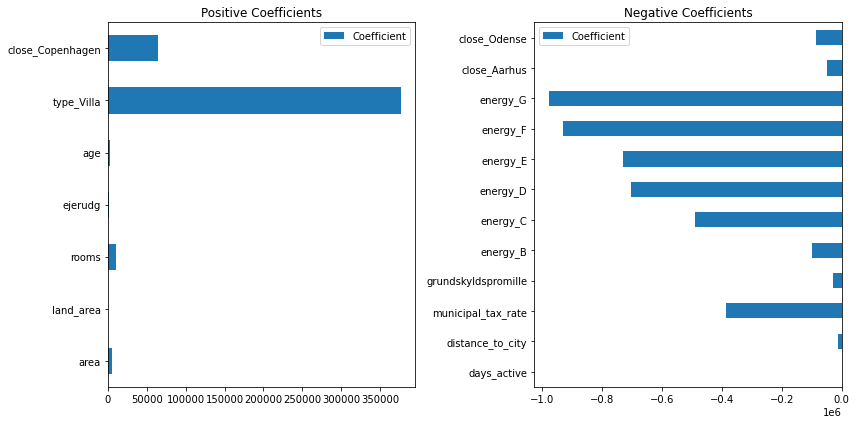

In [141]:
# Create a DataFrame with rescaled coefficients and feature names
coef_df = pd.DataFrame(rescaled_coefficients, X.columns, columns=['Coefficient'])

# Split coefficients into positive and negative parts
positive_coef = coef_df[coef_df['Coefficient'] > 0]
negative_coef = coef_df[coef_df['Coefficient'] < 0]

# Create subplots with positive and negative coefficients
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
positive_coef.plot(kind='barh', ax=ax1)
negative_coef.plot(kind='barh', ax=ax2)

ax1.set_title('Positive Coefficients')
ax2.set_title('Negative Coefficients')

plt.tight_layout()
plt.show()

## Lasso

In [310]:
def create_pipeline_lasso(degree, lambdas):
    return make_pipeline(PolynomialFeatures(degree=degree, include_bias=False),
                         StandardScaler(),
                         LassoCV(alphas=lambdas, cv=5, random_state=161193))

lambdas = np.logspace(-2, 4, 10) # Grid of lambdas
degree = 1

perform = []

for lambda_ in lambdas:
    
    pipe_lasso = create_pipeline_lasso(degree, lambdas)
    pipe_lasso.fit(X_dev, y_dev)
    
    y_pred = pipe_lasso.predict(X_test)
    rmse = np.sqrt(mse(y_pred, y_test))
    perform.append(rmse)

# Create a Series with performance and find parameter with lowest RMSE
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.idxmin()

y_pred = pipe_lasso.predict(X_test)  # Predict using the best lambda
r2 = r2_score(y_test, y_pred)

print(f"Degree {degree} Polynomial - R squared: {r2:.4f}")
print(f"Degree {degree} Polynomial - Best Lambda: {optimal:.8f}")
print(f"Degree {degree} Polynomial - RMSE: {hyperparam_perform[optimal]:.2f}")

Degree 1 Polynomial - R squared: 0.7400
Degree 1 Polynomial - Best Lambda: 0.01000000
Degree 1 Polynomial - RMSE: 1139247.32


In [363]:
degree = 2

perform = []

for lambda_ in lambdas:
    
    pipe_lasso = create_pipeline_lasso(degree, lambdas)
    pipe_lasso.fit(X_dev, y_dev)
    
    y_pred = pipe_lasso.predict(X_test)
    rmse = np.sqrt(mse(y_pred, y_test))
    perform.append(rmse)

# Create a Series with performance and find parameter with lowest RMSE
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.idxmin()

y_pred = pipe_lasso.predict(X_test)  # Predict using the best lambda
r2 = r2_score(y_test, y_pred)

print(f"Degree {degree} Polynomial - R squared: {r2:.4f}")
print(f"Degree {degree} Polynomial - Best Lambda: {optimal:.8f}")
print(f"Degree {degree} Polynomial - RMSE: {hyperparam_perform[optimal]:.2f}")

Degree 2 Polynomial - R squared: 0.8144
Degree 2 Polynomial - Best Lambda: 0.01000000
Degree 2 Polynomial - RMSE: 1146872.14


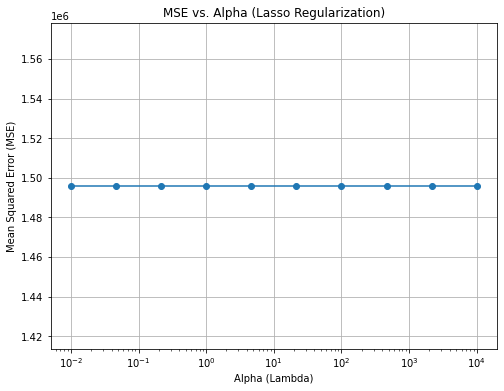

In [245]:
# Create a line plot of MSE values
plt.figure(figsize=(8, 6))
plt.plot(lambdas, perform, marker='o')
plt.xscale('log')  # Use a logarithmic scale for x-axis (optional)
plt.title('MSE vs. Alpha (Lasso Regularization)')
plt.xlabel('Alpha (Lambda)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

OPTIMAL LASSO

In [342]:
from sklearn.metrics import mean_squared_error as mse

scaler = StandardScaler()
poly_trans = PolynomialFeatures(degree=2)

# APPLY POLYNOMIAL TRANSFORMATION
X_train_poly = poly_trans.fit_transform(X_dev) 
X_test_poly = poly_trans.transform(X_test)

X_dev_st = scaler.fit_transform(X_train_poly)
X_test_st = scaler.transform(X_test_poly)

lasso_model = Lasso(alpha=0.01)  # Adjust the alpha parameter as needed
lasso_model.fit(X_dev_st, y_dev)

# Make predictions on the test set
y_pred = lasso_model.predict(X_test_st)

# Calculate the Mean Squared Error (MSE)
rmse = np.sqrt(mse(y_test, y_pred))
print("RMSE:",rmse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

RMSE: 971307.6098602478
R-squared: 0.8110158355570414


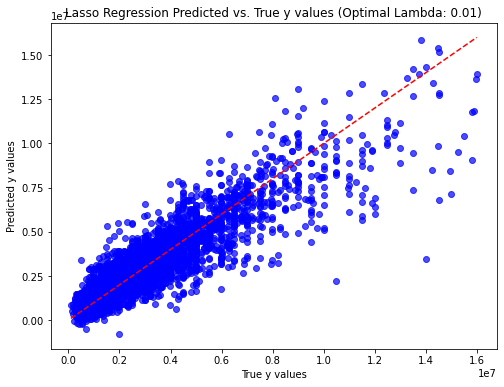

In [343]:
# Plot the predicted y values against true y values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('True y values')
plt.ylabel('Predicted y values')
plt.title(f'Lasso Regression Predicted vs. True y values (Optimal Lambda: {optimal:.2f})')
plt.grid(False)
plt.show()

## Ridge

In [181]:
def create_pipeline_ridge(degree,lambdas):
    return make_pipeline(PolynomialFeatures(degree=degree, include_bias=False), 
                               StandardScaler(),
                               RidgeCV(alphas=lambdas, cv=5))

lambdas = np.logspace(-2, 4, 10) # Grid of lambdas
degree = 1

perform = []

for lambda_ in lambdas:
    
    pipe_ridge = create_pipeline_ridge(degree, lambdas)
    pipe_ridge.fit(X_dev, y_dev)
    
    y_pred = pipe_ridge.predict(X_test)
    rmse = np.sqrt(mse(y_pred, y_test))
    perform.append(rmse)

# Create a Series with performance and find parameter with lowest RMSE
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.idxmin()

y_pred = pipe_ridge.predict(X_test)  # Predict using the best lambda
r2 = r2_score(y_test, y_pred)

print(f"Degree {degree} Polynomial - R squared: {r2:.4f}")
print(f"Degree {degree} Polynomial - Best Lambda: {optimal:.8f}")
print(f"Degree {degree} Polynomial - RMSE: {hyperparam_perform[optimal]:.2f}")

Degree 1 Polynomial - R squared: 0.7353
Degree 1 Polynomial - Best Lambda: 0.01000000
Degree 1 Polynomial - RMSE: 1139776.85


In [182]:
from sklearn.metrics import mean_squared_error as mse

degree = 2

perform = []

for lambda_ in lambdas:
    
    pipe_ridge = create_pipeline_ridge(degree, lambdas)
    pipe_ridge.fit(X_dev, y_dev)
    
    y_pred = pipe_ridge.predict(X_test)
    rmse = np.sqrt(mse(y_pred, y_test))
    perform.append(rmse)

# Create a Series with performance and find parameter with lowest RMSE
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.idxmin()

y_pred = pipe_ridge.predict(X_test)  # Predict using the best lambda
r2 = r2_score(y_test, y_pred)

print(f"Degree {degree} Polynomial - R squared: {r2:.4f}")
print(f"Degree {degree} Polynomial - Best Lambda: {optimal:.8f}")
print(f"Degree {degree} Polynomial - RMSE: {hyperparam_perform[optimal]:.2f}")

Degree 2 Polynomial - R squared: 0.8014
Degree 2 Polynomial - Best Lambda: 0.01000000
Degree 2 Polynomial - RMSE: 987300.49


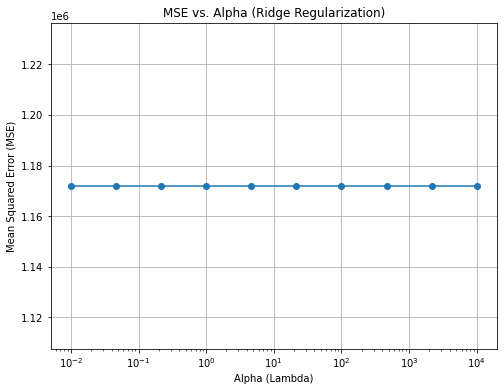

In [62]:
# Create a line plot of MSE values
plt.figure(figsize=(8, 6))
plt.plot(lambdas, perform, marker='o')
plt.xscale('log')  # Use a logarithmic scale for x-axis (optional)
plt.title('MSE vs. Alpha (Ridge Regularization)')
plt.xlabel('Alpha (Lambda)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error as mse

scaler = StandardScaler()
poly_trans = PolynomialFeatures(degree=2)

# APPLY POLYNOMIAL TRANSFORMATION
X_train_poly = poly_trans.fit_transform(X_dev) 
X_test_poly = poly_trans.transform(X_test)

X_dev_st = scaler.fit_transform(X_train_poly)
X_test_st = scaler.transform(X_test_poly)

ridge_model = Ridge(alpha=0.01)  # Adjust the alpha parameter as needed
ridge_model.fit(X_dev_st, y_dev)

# Make predictions on the test set
y_pred = ridge_model.predict(X_test_st)

# Calculate the Mean Squared Error (MSE)
rmse = np.sqrt(mse(y_test, y_pred))
print("RMSE:",rmse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

RMSE: 1158414.6759220238
R-squared: 0.8196302183239287


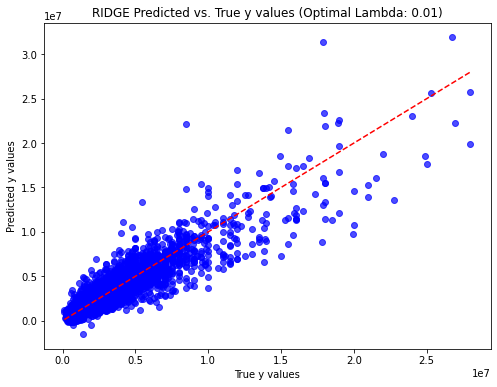

In [65]:
# Plot the predicted y values against true y values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('True y values')
plt.ylabel('Predicted y values')
plt.title(f'RIDGE: Predicted vs. True y values (Optimal Lambda: {optimal:.2f})')
plt.grid(False)
plt.show()

## Compare Models

### Learning curves

In [350]:
# LOAD FROM SCIKIT-LEARN
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=ridge_model,
                   X=X,
                   y=y,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=5)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))

mse_.head(10)

,Train,Test
sample size,,
1031,1.329973e+12,1.572555e+12
2063,1.249275e+12,1.475447e+12
3095,1.185822e+12,1.454551e+12
4127,1.184576e+12,1.983705e+12
5159,1.212185e+12,2.017575e+12
6191,1.253357e+12,1.569668e+12
7223,1.275103e+12,1.578147e+12
8255,1.304860e+12,1.555853e+12
9287,1.361024e+12,1.445825e+12


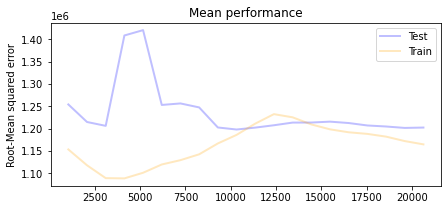

In [351]:
f_learn, ax = plt.subplots(figsize=(7,3))
ax.plot(train_sizes,np.sqrt(-test_scores.mean(1)), alpha=0.25, linewidth=2, label ='Test', color='blue') # negated, because we already use neg_MSE
ax.plot(train_sizes,np.sqrt(-train_scores.mean(1)), alpha=0.25, linewidth=2, label='Train', color='orange') # negated, because we already use neg_MSE

ax.set_title('Mean performance')
ax.set_ylabel('Root-Mean squared error')
ax.legend();

# Normal OLS for comparison

In [352]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Add a constant term to X
X = sm.add_constant(X)

# Fit OLS regression model
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     3614.
Date:                Mon, 21 Aug 2023   Prob (F-statistic):               0.00
Time:                        11:13:21   Log-Likelihood:            -3.9702e+05
No. Observations:               25799   AIC:                         7.941e+05
Df Residuals:                   25779   BIC:                         7.942e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                9.817e+06   2

C:\Users\marko\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# Data Visualization

In [72]:
df_final.columns

Index(['price', 'area', 'land_area', 'rooms', 'ejerudg', 'days_active',
       'distance_to_city', 'municipal_tax_rate', 'grundskyldspromille', 'age',
       'type_Villa', 'energy_B', 'energy_C', 'energy_D', 'energy_E',
       'energy_F', 'energy_G', 'close_Aarhus', 'close_Copenhagen',
       'close_Odense'],
      dtype='object')

In [75]:
# Specify the columns and statistics you want
selected_columns = ['price', 'area', 'rooms', 'ejerudg', 'age', 'days_active', 'distance_to_city', 'municipal_tax_rate', 'grundskyldspromille', 
                   'type_Villa']
selected_stats = ['count', 'mean', 'min', 'max']

# Calculate descriptive statistics
statistics = df_final[selected_columns].agg(selected_stats)
formatted_statistics = statistics.applymap(lambda x: int(x) if x == int(x) else int(round(x)))
formatted_statistics

,price,area,rooms,ejerudg,age,days_active,distance_to_city,municipal_tax_rate,grundskyldspromille,type_Villa
count,26352,26352,26352,26352,26352,26352,26352,26352,26352,26352
mean,2937402,145,5,2785,76,276,38,25,26,1
min,95000,16,1,244,-2,0,0,23,16,0
max,29495000,790,19,17205,823,4752,100,26,34,1


In [77]:
# Convert statistics to LaTeX table
latex_table = statistics.to_latex()

# Print or save the LaTeX table
print(latex_table)

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &         price &          area &         rooms &       ejerudg &           age &   days\_active &  distance\_to\_city &  municipal\_tax\_rate &  grundskyldspromille &    type\_Villa \\
\midrule
count &  2.635200e+04 &  26352.000000 &  26352.000000 &  26352.000000 &  26352.000000 &  26352.000000 &      26352.000000 &        26352.000000 &         26352.000000 &  26352.000000 \\
mean  &  2.937402e+06 &    145.496129 &      4.621774 &   2784.736339 &     76.496319 &    276.337849 &         37.953020 &           25.280553 &            26.157433 &      0.792767 \\
min   &  9.500000e+04 &     16.000000 &      1.000000 &    244.000000 &     -2.000000 &      0.000000 &          0.066130 &           23.100000 &            16.000000 &      0.000000 \\
max   &  2.949500e+07 &    790.000000 &     19.000000 &  17205.000000 &    823.000000 &   4752.000000 &         99.990634 &           26.300000 &            34.000000 &      1.000000 \\
\bottomrule
\end{tab